<a href="https://colab.research.google.com/github/j1ayizhao/datascienceA2/blob/main/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

<Axes: xlabel='FT%', ylabel='FG%'>

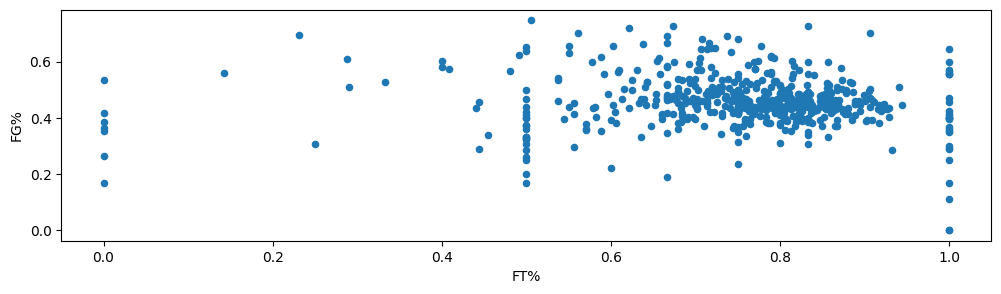

In [ ]:
#scatter plot of FT v. FG count of basketball stats
basketball.plot(x="FT%", y="FG%", figsize=(12, 3), kind="scatter")

There is a distinct cluster of points to the right, showing that majority of the players show both high FG% and high FT%. I think this is because players who are good at free throws have better shooting technique, so they tend to be better at making field goals as well.

Also, we can see that overall FT% are pretty high, while FG% is more variable. Which makes sense because field goals are generally harder to make since you have defenders actively trying to block the shot, while free throws are uncontested

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

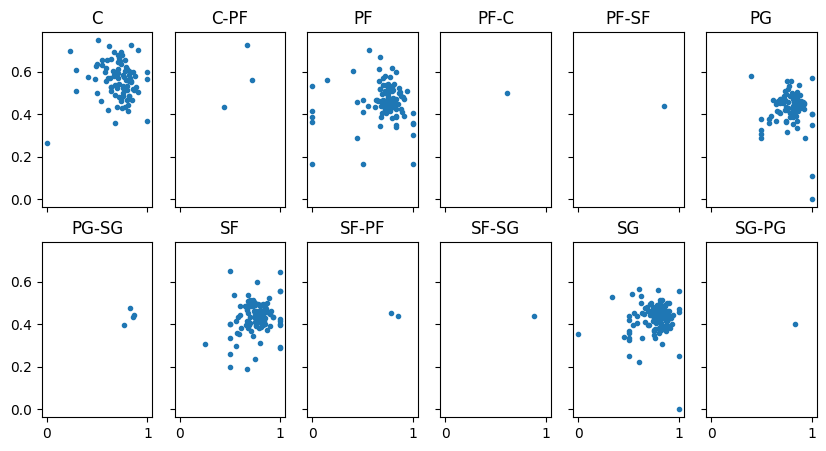

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:


Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The linear regression model didn't run on the full data set because there are clusters in the dataset that cause non-linearity. Additionally, this dataset has high leverage points are going to negatively affect the linear regression line, as they drag the slope around. They're especially apparent in graph C, where there is one point further away from the cluster at around y=0.2, which is going to significantly affect the direction of the slope. This causes our model to not be able to depict the data accurately.



---



## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [ ]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

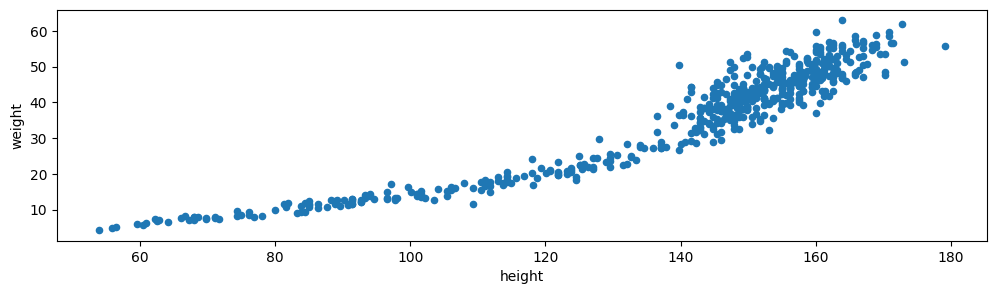

In [ ]:
#scatter plot of Height v. Weight count of the howell data set
howell.plot(x="height", y="weight", figsize=(12, 3), kind="scatter")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
#lh stands for linear howell
with pm.Model() as model_lh:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell.height)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    #inference data object
    idata_lh = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

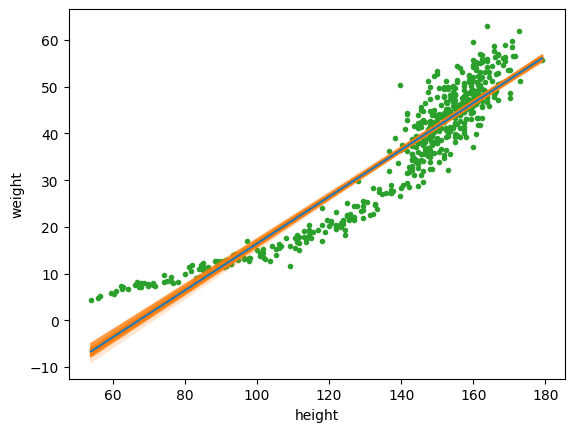

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lh, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict height and weight deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

All of the orange lines capture the positve trend between height and weight, but the model does not capture the curvature around the 100-140 heights. The model also seems to underestimate the weight for lower and higher heights.

In [ ]:
pm.sample_posterior_predictive(idata_lh, model=model_lh,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

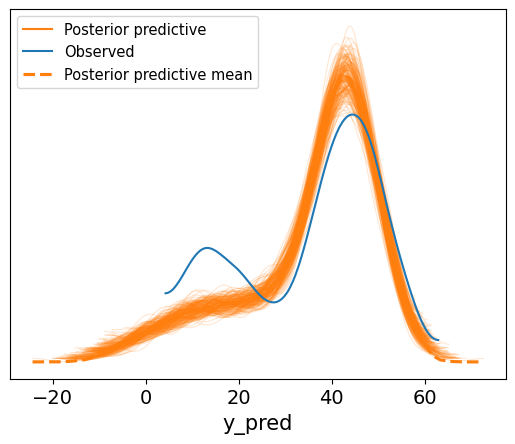

In [ ]:
az.plot_ppc(idata_lh, num_pp_samples=200, colors=["C1", "C0", "C1"])

From this ppc, we can see that the linear model doesn't fit our data very well, as it completely fails to capture the peak on the left. Additionally, it is predicting negative weights which is impossible.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_exp:
    # priors
    α = pm.Normal("α", sigma=10)  # intercept
    β = pm.Normal("β", sigma=10)  # growth rate

    # exponential function: exp(α + β * x)
    μ = pm.Deterministic("μ", pm.math.exp(α + β * howell.height))

    # prior for standard deviation
    σ = pm.HalfNormal("σ", sigma=10)

    # likelihood (still normal, but with exponential mean)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_exp = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

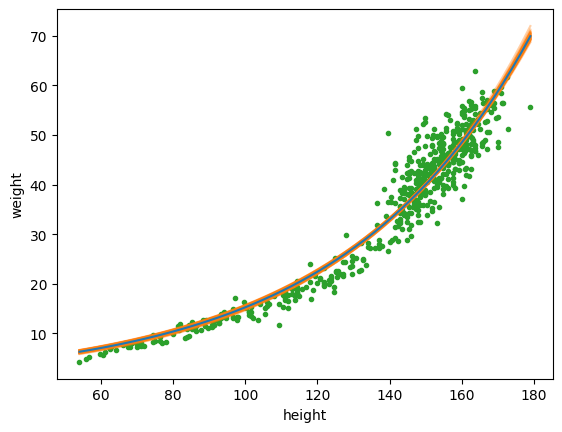

In [ ]:
# Grab 100 posterior samples
posterior_exp = az.extract(idata_exp, num_samples=100)

# grabbing x values for graphing
x_plot = xr.DataArray(np.linspace(howell.height.min(), howell.height.max(), 50), dims="plot_id")

# creates the expected line using the exponential function
mean_line_exp = np.exp(posterior_exp["α"].mean() + posterior_exp["β"].mean() * x_plot)

#  50 lines that our model came up with
lines_exp = np.exp(posterior_exp["α"] + posterior_exp["β"] * x_plot)

# set up plot
_, ax = plt.subplots()

# plots 50 other lines our model came up with
ax.plot(x_plot, lines_exp.T, c="C1", alpha=0.2, label="lines")

# plots the mean line
ax.plot(x_plot, mean_line_exp, c="C0", label="mean line")

# plot the raw data
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)

# label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

This model is a much better fit of the howell data. It captures the curvature of the upwards trend, and the estimation of the weights are much more accurate. I improved my previous model by using an exponential function for the expected line, because that's the relationship I thought the data points resembled

In [ ]:
pm.sample_posterior_predictive(idata_exp, model=model_exp,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

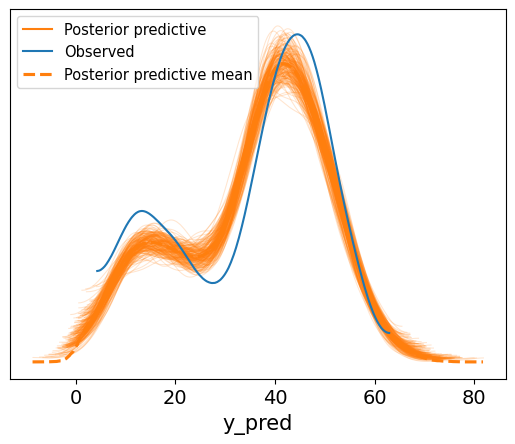

In [ ]:
az.plot_ppc(idata_exp, num_pp_samples=200, colors=["C1", "C0", "C1"])

From the ppc of my new model, we can see that it now captures the left peak of our data set whereas it didn't before. This is because the exponential function models the curvature of the data set more accurately and better represents the relationship, whereas the linear model from task 5 didn't account for the curvature of our data